![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 3</a>

## Neural Networks

### Sample Problem: Detecting Products with Electrical Plugs in Amazon Marketplace Products

In this notebook, we build, train, validate, and test a Neural Network with PyTorch to predict the __target_label__ field (plug or no plug) of the Amazon electric plug dataset. 


1. <a href="#1">Read the datasets</a>
2. <a href="#2">Data Processing</a>
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a>
    * <a href="#23">Data Preprocessing (cleaning)</a>
    * <a href="#24">Train - Validation - Test Datasets</a>
    * <a href="#25">Data processing with Pipeline and ColumnTransformer</a>
3. <a href="#3">Neural Network Training and Validation</a>
4. <a href="#4">Test the Neural Network</a>
5. <a href="#5">Improvement ideas</a>


__Dataset schema:__ 
- __ASIN__: Product ASIN
- __target_label:__ Binary field with values in {0,1}. A value of 1 show ASIN has a plug, otherwise 0.
- __ASIN_STATIC_ITEM_NAME:__ Title of the ASIN.
- __ASIN_STATIC_PRODUCT_DESCRIPTION:__ Description of the ASIN
- __ASIN_STATIC_GL_PRODUCT_GROUP_TYPE:__ GL information for the ASIN.
- __ASIN_STATIC_ITEM_PACKAGE_WEIGHT:__ Weight of the ASIN.
- __ASIN_STATIC_LIST_PRICE:__ Price information for the ASIN.
- __ASIN_STATIC_BATTERIES_INCLUDED:__ Information whether batteries are included along with the product.
- __ASIN_STATIC_BATTERIES_REQUIRED:__ Information whether batteries are required for using the product.
- __ASIN_STATIC_ITEM_CLASSIFICATION:__ Item classification of whether it is a standalone or bundle parent item etc


In [1]:
# import the datasets
import boto3
import os
from os import path
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np                    
import re, string
import nltk
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
import torch
from torch import nn

## 1. <a name="1">Read the datasets</a>
(<a href="#0">Go to top</a>)

Let's read the datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).

In [2]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
 
df = pd.read_csv('../../data/review/asin_electrical_plug_training_data.csv')
test_data = pd.read_csv('../../data/review/asin_electrical_plug_test_data.csv')

print('The shape of the training dataset is:', df.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (55109, 10)
The shape of the test dataset is: (6124, 10)


## 2. <a name="2">Data Processing</a>
(<a href="#0">Go to top</a>)

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the dataset.

In [3]:
# Print the first five rows
# NaN means missing data
df.head()

,ASIN,target_label,ASIN_STATIC_ITEM_NAME,ASIN_STATIC_PRODUCT_DESCRIPTION,ASIN_STATIC_GL_PRODUCT_GROUP_TYPE,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE,ASIN_STATIC_BATTERIES_INCLUDED,ASIN_STATIC_BATTERIES_REQUIRED,ASIN_STATIC_ITEM_CLASSIFICATION
0,B000816IUC,0,Bruder 02921 Jeep Wrangler Unlimited with Hors...,NEW! Jeep Wrangler by Bruder with trailer come...,gl_toy,3.450000,36.66,False,False,base_product
1,B003674A1Y,0,"Lucky Reptile OV-2 OpenAir Vivarium, Medium",Größe: 40x40x60 cm. <p>Lucky Reptile OpenAir V...,gl_pet_products,2.690000,24.68,False,False,base_product
2,B007ECONV4,0,"Klarfit KS5DG Chin Up Bar (150kg Max Load, Doo...",<p><b>Highly flexible pull-up bar with six con...,gl_sports,8.112928,NaN,False,False,base_product
3,B00D89465A,0,Liverpool FC Stripe Wallpaper,This fantastic Liverpool Wallpaper is ideal fo...,gl_home,1.763680,8.33,NaN,NaN,base_product
4,B001MJ0BN4,0,Rolson 68889 Oil Tanned Double Tool Pouch,"Eleven pockets, two fixed metal hammer holders...",gl_biss,2.733704,27.38,NaN,NaN,base_product


In [4]:
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55109, 10)


In [5]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55109 entries, 0 to 55108
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ASIN                               55109 non-null  object 
 1   target_label                       55109 non-null  int64  
 2   ASIN_STATIC_ITEM_NAME              55109 non-null  object 
 3   ASIN_STATIC_PRODUCT_DESCRIPTION    31727 non-null  object 
 4   ASIN_STATIC_GL_PRODUCT_GROUP_TYPE  55109 non-null  object 
 5   ASIN_STATIC_ITEM_PACKAGE_WEIGHT    55027 non-null  float64
 6   ASIN_STATIC_LIST_PRICE             41182 non-null  float64
 7   ASIN_STATIC_BATTERIES_INCLUDED     45016 non-null  object 
 8   ASIN_STATIC_BATTERIES_REQUIRED     40688 non-null  object 
 9   ASIN_STATIC_ITEM_CLASSIFICATION    55097 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.6+ MB


In [6]:
# This prints basic statistics for numerical columns
df.describe()

,target_label,ASIN_STATIC_ITEM_PACKAGE_WEIGHT,ASIN_STATIC_LIST_PRICE
count,55109.000000,55027.000000,4.118200e+04
mean,0.036618,31.130529,1.563334e+02
std,0.187825,458.771422,1.754345e+04
min,0.000000,0.000000,1.160000e+00
25%,0.000000,1.520000,1.667000e+01
50%,0.000000,2.513244,3.268500e+01
75%,0.000000,5.555592,6.999000e+01
max,1.000000,29500.000000,3.560000e+06


#### Target distribution

Let's check our target distribution.

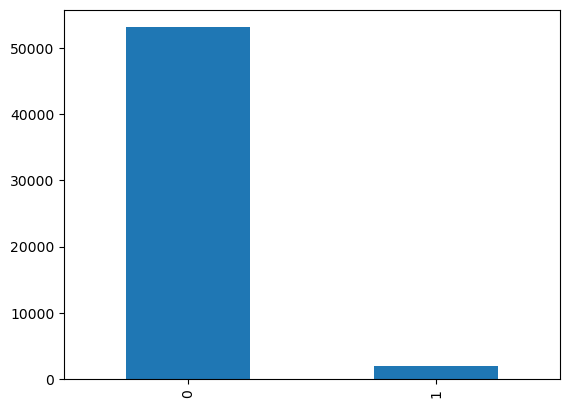

In [7]:
df['target_label'].value_counts().plot.bar()
plt.show()

We notice that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). In this case, we have a lot of class 0 ("no plug") records and very few class 1 ("plug") records. 

#### Dataset features

Let's now print the features of our dataset.

In [8]:
# use this for datasets with more columns, to print all columns
# (beware, if might raise memory errors when trying to print the text features values!)
# np.set_printoptions(threshold=np.inf) 

# This prints the column labels of the dataframe
print('All dataset columns:')
print(df.columns.values)

# This prints the column labels of the features identified as numerical
print('Numerical columns:')
print(df.select_dtypes(include=np.number).columns.values)

# This prints the column labels of the features identified as numerical
print('Categorical columns:')
print(df.select_dtypes(include='object').columns.values)

All dataset columns:
['ASIN' 'target_label' 'ASIN_STATIC_ITEM_NAME'
 'ASIN_STATIC_PRODUCT_DESCRIPTION' 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE'
 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE'
 'ASIN_STATIC_BATTERIES_INCLUDED' 'ASIN_STATIC_BATTERIES_REQUIRED'
 'ASIN_STATIC_ITEM_CLASSIFICATION']
Numerical columns:
['target_label' 'ASIN_STATIC_ITEM_PACKAGE_WEIGHT' 'ASIN_STATIC_LIST_PRICE']
Categorical columns:
['ASIN' 'ASIN_STATIC_ITEM_NAME' 'ASIN_STATIC_PRODUCT_DESCRIPTION'
 'ASIN_STATIC_GL_PRODUCT_GROUP_TYPE' 'ASIN_STATIC_BATTERIES_INCLUDED'
 'ASIN_STATIC_BATTERIES_REQUIRED' 'ASIN_STATIC_ITEM_CLASSIFICATION']


### 2.2 <a name="22">Select features to build the model</a>
(<a href="#2">Go to Data Processing</a>)

This time we build a model using all features (except __ASIN__). That is, we build a classifier including __numerical, categorical__ and __text__ features. 

In [9]:
# Grab model features/inputs and target/output
numerical_features = ["ASIN_STATIC_ITEM_PACKAGE_WEIGHT",
                      "ASIN_STATIC_LIST_PRICE"]

categorical_features = ['ASIN_STATIC_GL_PRODUCT_GROUP_TYPE',
               'ASIN_STATIC_BATTERIES_INCLUDED',
               'ASIN_STATIC_BATTERIES_REQUIRED',
               'ASIN_STATIC_ITEM_CLASSIFICATION']

text_features = ['ASIN_STATIC_ITEM_NAME',
                 'ASIN_STATIC_PRODUCT_DESCRIPTION']

model_features = numerical_features + categorical_features + text_features
model_target = 'target_label'


### 2.3 <a name="23">Data Preprocessing (Cleaning)</a>
(<a href="#2">Go to Data Processing</a>)

Before data processing, we first clean the dataset.


### Cleaning numerical features 

Let's examine the numerical features.

In [10]:
for i in range(0,len(numerical_features)):
    print(df[numerical_features[i]].value_counts(bins=10, sort=False))

(-29.501, 2950.0]     54910
(2950.0, 5900.0]         50
(5900.0, 8850.0]         28
(8850.0, 11800.0]        19
(11800.0, 14750.0]        8
(14750.0, 17700.0]        7
(17700.0, 20650.0]        1
(20650.0, 23600.0]        0
(23600.0, 26550.0]        1
(26550.0, 29500.0]        3
Name: ASIN_STATIC_ITEM_PACKAGE_WEIGHT, dtype: int64
(-3558.84, 356001.044]        41181
(356001.044, 712000.928]          0
(712000.928, 1068000.812]         0
(1068000.812, 1424000.696]        0
(1424000.696, 1780000.58]         0
(1780000.58, 2136000.464]         0
(2136000.464, 2492000.348]        0
(2492000.348, 2848000.232]        0
(2848000.232, 3204000.116]        0
(3204000.116, 3560000.0]          1
Name: ASIN_STATIC_LIST_PRICE, dtype: int64


__Outliers__. We have an outlier data in the last bin of the second numerical feature. We will remove this data point below.

In [11]:
#print(df[df[numerical_features[1]] > 3000000])
dropIndexes = df[df[numerical_features[1]] > 3000000].index
df.drop(dropIndexes , inplace=True)

In [12]:
df[numerical_features[1]].value_counts(bins=10, sort=False)

(-13.838999999999999, 1500.944]    41147
(1500.944, 3000.728]                  15
(3000.728, 4500.512]                   8
(4500.512, 6000.296]                   3
(6000.296, 7500.08]                    2
(7500.08, 8999.864]                    3
(8999.864, 10499.648]                  0
(10499.648, 11999.432]                 1
(11999.432, 13499.216]                 0
(13499.216, 14999.0]                   2
Name: ASIN_STATIC_LIST_PRICE, dtype: int64

__Missing Numerical Values__. Let's check missing values for these numerical features.

In [13]:
print(df[numerical_features].isna().sum())

ASIN_STATIC_ITEM_PACKAGE_WEIGHT       82
ASIN_STATIC_LIST_PRICE             13927
dtype: int64


As a quick fix, we will apply mean imputation. This will replace the missing values with the mean value of the corresponding column.

__Note on imputation__: The statistically correct way to perform mean/mode imputation before training an ML model is to compute the column-wise means on the training data only, and then use these values to impute missing data in the train, validation, and test sets. So, we'll need to split our training dataset first. Same goes for any other transformations we would like to apply to these numerical features, such as scaling or encoding. 

### Cleaning categorical features 

Let's also examine the categorical features.

In [14]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
[False nan True]
ASIN_STATIC_BATTERIES_REQUIRED
[False nan True]
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' nan 'variation_parent']


__Note on boolean type__: Most categories are strings, except the __nan__s, and the booleans __False__ and __True__. The booleans will raise errors when trying to encode the categoricals with sklearn encoders, none of which accept boolean types. If using pandas get_dummies to one-hot encode the categoricals, there's no need to convert the booleans. However, get_dummies is trickier to use with sklearn's Pipeline and GridSearch. 

One way to deal with the booleans is to convert them to strings, by using a mask and a map changing only the booleans.

In [15]:
# Converting booleans to strings for a dataframe
def convert_bool_to_str(dataframe):
    mask = dataframe.applymap(type) != bool
    do = {True: 'TRUE', False: 'FALSE'}
    return dataframe.where(mask, dataframe.replace(do))

In [16]:
# Convert booleans to strings for training and test datasets
df_masked = convert_bool_to_str(df)
test_data_masked = convert_bool_to_str(test_data)

In [17]:
for c in categorical_features:
    print(c)
    print(df_masked[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
['FALSE' nan 'TRUE']
ASIN_STATIC_BATTERIES_REQUIRED
['FALSE' nan 'TRUE']
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' nan 'variation_parent']


Another way to handle the booleans is to convert them to strings by changing the type of all categoricals to 'str'. This will also affect the nans, basically performing imputation of the nans with a 'nans' placeholder value! 

Applying the type conversion to both categoricals and text features, takes care of the nans in the text fields as well. In case other imputations are planned for the categoricals and/or test fields, notice that the masking shown above leaves the nans unchanged.

In [18]:
# Perform boolean to string operation on training and test datasets
df[categorical_features + text_features] = df[categorical_features + text_features].astype('str')
test_data[categorical_features + text_features] = test_data[categorical_features + text_features].astype('str')

In [19]:
for c in categorical_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_GL_PRODUCT_GROUP_TYPE
['gl_toy' 'gl_pet_products' 'gl_sports' 'gl_home' 'gl_biss'
 'gl_home_improvement' 'gl_baby_product' 'gl_office_product'
 'gl_lawn_and_garden' 'gl_musical_instruments' 'gl_camera' 'gl_kitchen'
 'gl_automotive' 'gl_electronics' 'gl_personal_care_appliances' 'gl_pc'
 'gl_drugstore' 'gl_luggage' 'gl_wireless' 'gl_home_entertainment'
 'gl_major_appliances' 'gl_apparel' 'gl_beauty' 'gl_shoes' 'gl_watch'
 'gl_video_games' 'gl_book' 'gl_music' 'gl_fresh_ambient']
ASIN_STATIC_BATTERIES_INCLUDED
['False' 'nan' 'True']
ASIN_STATIC_BATTERIES_REQUIRED
['False' 'nan' 'True']
ASIN_STATIC_ITEM_CLASSIFICATION
['base_product' 'nan' 'variation_parent']


Converting categoricals into useful numerical features, will also have to wait until after the train/test split.

### Cleaning text features 

Also a good idea to look at the text fields. Text cleaning can be performed here, before train/validation split, with less code.

In [20]:
for c in text_features:
    print(c)
    print(df[c].unique()) #value_counts())

ASIN_STATIC_ITEM_NAME
['Bruder 02921 Jeep Wrangler Unlimited with Horse Trailer incl. 1 Horse'
 'Lucky Reptile OV-2 OpenAir Vivarium, Medium'
 'Klarfit KS5DG Chin Up Bar (150kg Max Load, Door Mounted & Steel Frame) - Black'
 ...
 'Hama 00096150 file storage box/organizer - file storage boxes & organizers (177 x 225 x 185 mm)'
 'Vogels EFW 8125 MOTION S Wall Mount with Arm for 19 - 32-Inch LCD/Plasma TV'
 'Rexel Nyrex Slimview Display Book A4 Black (50 Pockets)']
ASIN_STATIC_PRODUCT_DESCRIPTION
['NEW! Jeep Wrangler by Bruder with trailer comes with a horse - which makes it a great gift for the equestrian in your family as well as for collectors of unique toys. This well designed combination urges children to use their imagination in constructive play. The horse trailer has a stabilizer leg, a side door that opens and is compatible with Pro Series Tractors and Unimogs. Dimensions: L650 x W140 x H190mm.'
 'Größe: 40x40x60 cm. <p>Lucky Reptile OpenAir Vivarium</p> <p>Das OpenAir Vivarium b

We re-use the helper functions from the 'Text processing' notebook.

In [21]:
# Prepare cleaning functions

stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # lowercase and strip leading/trailing white space
    text = text.lower().strip()
    
    # remove HTML tags
    text = re.compile('<.*?>').sub('', text)
    
    # remove punctuation
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    
    # remove extra white space
    text = re.sub('\s+', ' ', text)
    
    return text

def lexiconProcess(text, stop_words, stemmer):
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))
    text = " ".join(filtered_sentence)
    
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)


__Warning__: The text cleaning process can take a long time to complete, depending on the size of the text data!

In [22]:
# Clean the text features
for c in text_features:
    print('Text cleaning: ', c)
    df[c] = [cleanSentence(item, stop_words, stemmer) for item in df[c].values]
    test_data[c] = [cleanSentence(item, stop_words, stemmer) for item in test_data[c].values]

Text cleaning:  ASIN_STATIC_ITEM_NAME
Text cleaning:  ASIN_STATIC_PRODUCT_DESCRIPTION


The cleaned text features of the training and test dataset are ready to be vectorized.

### 2.4 <a name="24">Train - Validation - Test Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We have already split the original dataset into two data files: __training__ data file (asin_electrical_plug_training_data.csv) with __90%__ of the samples and the __test__ data file (asin_electrical_plug_test_data.csv) with the remaining __10%__. We further split our training dataset into training and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [23]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(df, test_size=0.15, shuffle=True, random_state=23)

# Print the shapes of the Train - Validation - Test Datasets
print('Train - Validation - Test Datasets shapes: ', train_data.shape, val_data.shape, test_data.shape)


Train - Validation - Test Datasets shapes:  (46841, 10) (8267, 10) (6124, 10)


### Target balancing

This dataset is imbalanced, as one class dominates the other. One way to address the imbalanced dataset is upsampling the rare the class, to have equal number of samples for each class. 

__Important note:__ We fix the imbalance only in training set. We shouldn't change the validation and test sets, they should follow the original distribution.

In [24]:
print(train_data.shape, val_data.shape, test_data.shape)

print(sum(train_data[model_target] == 0))
print(sum(train_data[model_target] == 1))

(46841, 10) (8267, 10) (6124, 10)
45131
1710


In [25]:
plug_products = train_data[train_data[model_target] == 1]
no_plug_products = train_data[train_data[model_target] == 0]

upsampled_plug_products = plug_products.sample(n=len(no_plug_products), replace=True, random_state=42)

train_data = pd.concat([no_plug_products, upsampled_plug_products])
train_data = shuffle(train_data)

In [26]:
print(train_data.shape, val_data.shape, test_data.shape)

print(sum(train_data[model_target] == 0))
print(sum(train_data[model_target] == 1))

(90262, 10) (8267, 10) (6124, 10)
45131
45131


### 2.5 <a name="25">Data processing with Pipeline and ColumnTransformer</a>
(<a href="#2">Go to Data Processing</a>)

We can use the composite Pipeline of Day 2 to train and tune a neural network in sklearn, using its implementation of neural network __MLPClassifier__. However, sklearn is not a neural network framework, lacking access to large scale optimization techniques with GPU support and more neural network related utility functions. 
 
We instead build a neural network with __PyTorch__. While for classic, non-neural algorithms, PyTorch is not particularly useful, using an actual deep learning framework for neural network experimentation provides more flexibility and customization.

Choice of model and hosting platform aside, we can still reuse the collective ColumnTransformer from Day 2 to preprocess the data for neural network training, validation and test, ensuring that the transformations learned on the train data are performed accordingly on the training, validation and test datasets.

In [27]:
### COLUMN_TRANSFORMER ###
##########################

# Preprocess the numerical features
numerical_processor = Pipeline([
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('num_scaler', MinMaxScaler()) # Shown in case is needed, not a must with Decision Trees
                                ])
                  
# Preprocess the categorical features
categorical_processor = Pipeline([
    ('cat_imputer', SimpleImputer(strategy='constant', fill_value='missing')), # Shown in case is needed, no effect here as we already imputed with 'nan' strings
    ('cat_encoder', OneHotEncoder(handle_unknown='ignore')) # handle_unknown tells it to ignore (rather than throw an error for) any value that was not present in the initial training set.
                                ])

# Preprocess 1st text feature
text_processor_0 = Pipeline([
    ('text_vectorizer_0', CountVectorizer(binary=True, max_features=50))
                                ])

# Preprocess 2nd text feature (larger vocabulary)
text_processor_1 = Pipeline([
    ('text_vectorizer_1', CountVectorizer(binary=True, max_features=150))
                                ])

# Combine all data preprocessors from above (add more, if you choose to define more!)
# For each processor/step specify: a name, the actual process, and finally the features to be processed
data_processor = ColumnTransformer([
    ('numerical_processing', numerical_processor, numerical_features),
    ('categorical_processing', categorical_processor, categorical_features),
    ('text_processing_0', text_processor_0, text_features[0]),
    ('text_processing_1', text_processor_1, text_features[1])
                                    ]) 

# Visualize the data processing pipeline
from sklearn import set_config
set_config(display='diagram')
data_processor

### DATA PROCESSING ###
#######################

# Get train data to train the network
X_train = train_data[model_features]
y_train = train_data[model_target].values

# Get validation data to validate the network 
X_val = val_data[model_features]
y_val = val_data[model_target].values

# Get test data to test the network for submission to the leaderboard
X_test = test_data[model_features]
y_test = test_data[model_target].values

print('Datasets shapes before processing: ', X_train.shape, X_val.shape, X_test.shape)

X_train = data_processor.fit_transform(X_train).toarray()
X_val = data_processor.transform(X_val).toarray()
X_test = data_processor.transform(X_test).toarray()

print('Datasets shapes after processing: ', X_train.shape, X_val.shape, X_test.shape)


Datasets shapes before processing:  (90262, 8) (8267, 8) (6124, 8)
Datasets shapes after processing:  (90262, 239) (8267, 239) (6124, 239)


## 3. <a name="3">Neural Network Training and Validation</a>
(<a href="#0">Go to top</a>)

We use Pytorch to build a neural network and fit to the training data. We also use the validation data to check performance at the end of each training iteration.

For more details on Pytorch and some starter tutorials, you check this out.

In [28]:
import time

######################
# Hyper-paramaters of the system
batch_size = 16
num_epochs = 15
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Let's our data into Pytorch tensors

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

# Use PyTorch DataLoaders to load the data in batches
train_dataset = torch.utils.data.TensorDataset(X_train,
                                               y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

######################
# Create a simple MultiLayer Perceptron using the Sequential mode - add things in sequence
#  with two hidden layers of size 64 and 64 
#  some dropouts attached to the hidden layers
#  one output layer

net = nn.Sequential(
    nn.Linear(in_features=239,     # Input shape of 239 is expected
              out_features=64),    # Linear layer-1 with 64 units
    nn.ReLU(),                     # Tanh activation is applied
    nn.Dropout(p=.4),              # Apply random 40% drop-out to layer_1
    nn.Linear(64, 64),             # Linear layer-2 with 64 units  
    nn.ReLU(),                     # Tanh activation is applied
    nn.Dropout(p=.3),              # Apply random 30% drop-out to layer_2
    nn.Linear(64, 2)               # Output layer with two units
).to(device)               

def xavier_init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

net.apply(xavier_init_weights)

######################
# Define the loss function and the trainer

# Choose Binary Cross Entropy loss for this classification problem
loss = nn.CrossEntropyLoss()

# Choose Stochastic Gradient Descent - can also experiment with other optimizers
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

######################
# Network Training and Validation

# Starting the outer epoch loop (epoch = full pass through our dataset)
for epoch in range(num_epochs):
    start = time.time()
    
    training_loss = 0.0
    
    # Training loop: (with autograd and trainer steps)
    # This loop does the training of the neural network
    # Weights are updated here
    net.train() # Activate training mode (dropouts etc.)
    for data, target in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        # forward + backward + optimize
        output = net(data)
        L = loss(output, target)
        L.backward()
        optimizer.step()
        # add batch loss
        training_loss += L.item()
    
    net.eval() # Activate eval mode (don't use dropouts etc.)
    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = loss(val_predictions, y_val).item()
    
    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)
    
    end = time.time()
    print("Epoch %s. Train_loss %f Validation_loss %f Seconds %f" % \
          (epoch, training_loss, val_loss, end-start))

Epoch 0. Train_loss 0.043854 Validation_loss 0.000086 Seconds 4.878134
Epoch 1. Train_loss 0.042772 Validation_loss 0.000084 Seconds 4.904323
Epoch 2. Train_loss 0.042100 Validation_loss 0.000082 Seconds 5.096611
Epoch 3. Train_loss 0.041259 Validation_loss 0.000079 Seconds 4.835706
Epoch 4. Train_loss 0.040373 Validation_loss 0.000077 Seconds 4.981168
Epoch 5. Train_loss 0.039623 Validation_loss 0.000075 Seconds 4.837006
Epoch 6. Train_loss 0.038860 Validation_loss 0.000074 Seconds 4.847301
Epoch 7. Train_loss 0.038191 Validation_loss 0.000073 Seconds 4.815667
Epoch 8. Train_loss 0.037662 Validation_loss 0.000071 Seconds 4.892453
Epoch 9. Train_loss 0.037147 Validation_loss 0.000071 Seconds 4.890587
Epoch 10. Train_loss 0.036694 Validation_loss 0.000070 Seconds 5.070260
Epoch 11. Train_loss 0.036382 Validation_loss 0.000069 Seconds 5.267072
Epoch 12. Train_loss 0.035987 Validation_loss 0.000068 Seconds 7.628196
Epoch 13. Train_loss 0.035558 Validation_loss 0.000068 Seconds 5.799572
Ep

## 4. <a name="4">Test the Neural Network</a>
(<a href="#0">Go to top</a>)

And now, let's evaluate the performance of the trained network on the test set.

In [29]:
from sklearn.metrics import classification_report

net.eval() # Activate eval mode (don't use dropouts etc.)

# Getting test predictions
predictions = net(X_test)

# Printing performance on the test data
print(classification_report(y_test.cpu().numpy(), predictions.argmax(axis=1).cpu().detach().numpy()))

              precision    recall  f1-score   support

           0       0.98      0.73      0.83      5898
           1       0.08      0.63      0.14       226

    accuracy                           0.72      6124
   macro avg       0.53      0.68      0.49      6124
weighted avg       0.95      0.72      0.81      6124



## 5. <a name="5">Improvement Ideas</a>
(<a href="#0">Go to top</a>)

* Further tune network parameters (architecture, # layers, # hidden neurons, activation functions, weights initialization, dropout, optimizer, learning rate, batch size, # epochs), while closely monitoring the loss function and the accuracy on both training and validation as a function of number of epochs.